In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from utils import *
from tests import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Logistic regression

## heart

In [2]:
%%time
dataset = "heart"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness const: ", L)
print("Average smoothness const: ", average_L)
print("Worst smoothness const: ", worst_L)
print("Percentage of non-zeros: ", sparsity_A)

Number of functions:  270 , dimension:  13
Smoothness const:  26710.680138975218
Average smoothness const:  27147.725435185188
Worst smoothness const:  90369.64000000001
Percentage of non-zeros:  0.750997150997151
CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 28.2 ms


### Find the solution (Run this code only once)

In [3]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [4]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-18)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30420D+02    |proj g|=  1.35674D+02

At iterate    1    f=  1.53576D+01    |proj g|=  1.05991D+02

At iterate    2    f=  7.25120D+00    |proj g|=  3.67496D+01

At iterate    3    f=  6.90595D+00    |proj g|=  3.73242D+01

At iterate    4    f=  6.54165D+00    |proj g|=  1.50821D+01

At iterate    5    f=  6.39694D+00    |proj g|=  1.17775D+01

At iterate    6    f=  6.03566D+00    |proj g|=  2.22461D+01

At iterate    7    f=  5.16484D+00    |proj g|=  3.35019D+01

At iterate    8    f=  3.48902D+00    |proj g|=  5.75619D+01

At iterate    9    f=  2.44443D+00    |proj g|=  4.05822D+01

At iterate   10    f=  1.96005D+00    |proj g|=  2.18241D+00

At iterate   11    f=  1.94949D+00    |proj g|=  2.14311D+00

At iterate   12    f=  1.02385D+00    |proj g|=  5.01816D+00

At iterate   13    f=  9.2

 This problem is unconstrained.



At iterate   81    f=  3.48928D-01    |proj g|=  5.46565D-02

At iterate   82    f=  3.48917D-01    |proj g|=  2.86746D-02

At iterate   83    f=  3.48912D-01    |proj g|=  7.54304D-03

At iterate   84    f=  3.48911D-01    |proj g|=  7.64079D-03

At iterate   85    f=  3.48908D-01    |proj g|=  1.25300D-02

At iterate   86    f=  3.48907D-01    |proj g|=  3.20764D-02

At iterate   87    f=  3.48904D-01    |proj g|=  2.67805D-02

At iterate   88    f=  3.48876D-01    |proj g|=  1.34163D-02

At iterate   89    f=  3.48826D-01    |proj g|=  4.79212D-02

At iterate   90    f=  3.48738D-01    |proj g|=  2.54346D-02

At iterate   91    f=  3.48703D-01    |proj g|=  1.70629D-01

At iterate   92    f=  3.48617D-01    |proj g|=  7.88083D-02

At iterate   93    f=  3.48551D-01    |proj g|=  2.32834D-02

At iterate   94    f=  3.48539D-01    |proj g|=  2.31817D-02

At iterate   95    f=  3.48519D-01    |proj g|=  4.26030D-02

At iterate   96    f=  3.48494D-01    |proj g|=  4.90746D-02

At iter

In [5]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

### Noise distribution

In [6]:
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

In [7]:
%%time
x = deepcopy(x_star)
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 30 ms, sys: 417 µs, total: 30.4 ms
Wall time: 51.1 ms


In [8]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean(grad_deviations**2 - mu))
print(mu)
print(sigma)

70.54703430486089
108.84347350641079


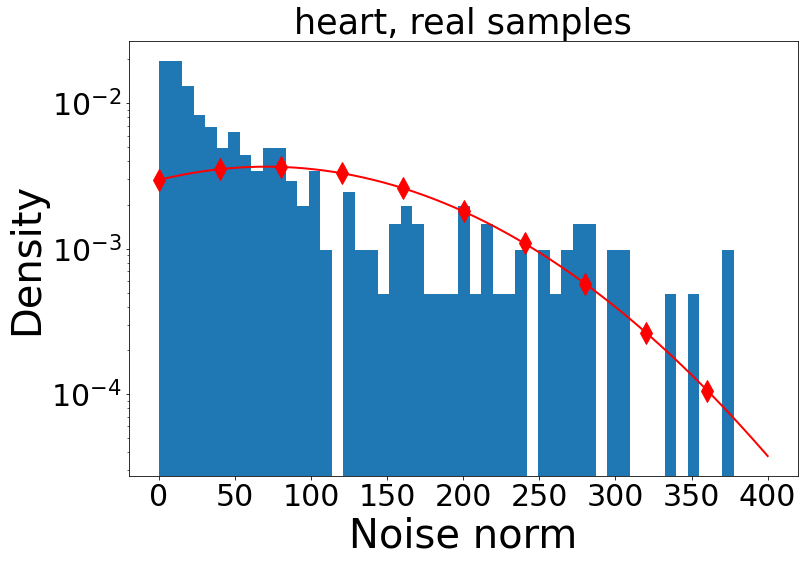

In [9]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=50, density=1, log=True)
temp2 = np.linspace(0, 400, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('heart, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/heart_real.pdf", bbox_inches='tight')

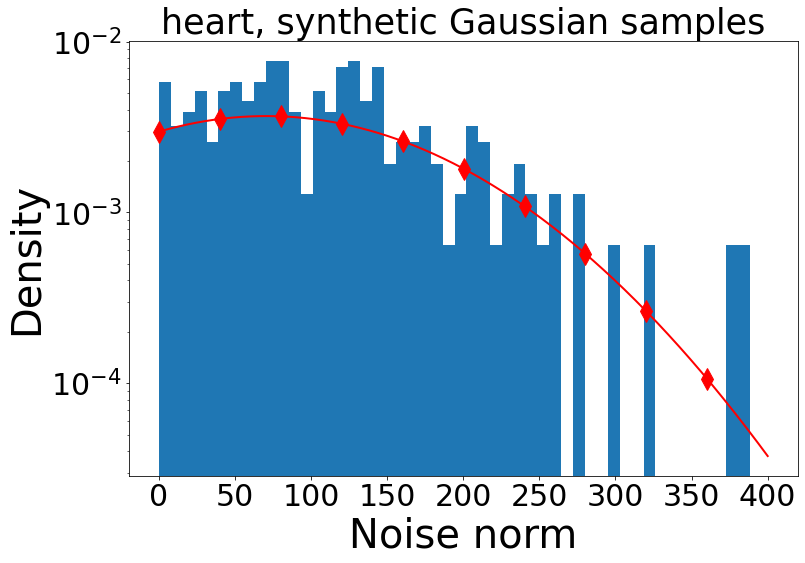

In [10]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=50, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
temp2 = np.linspace(0, 400, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('heart, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/heart_synthetic.pdf", bbox_inches='tight')

### Tests

In [11]:
shift_param = 0.1
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = 0
l1 = 0
batch_size = 20
M = int(2*m/batch_size)
gamma = 1.0/(L+l2)*0.05
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)
lambd = 2*np.sqrt(2)*(L+l2)*norm(x_star-x_init)*0.001
lambd_schedule = [lambd, 1000, 0.9]
S = 20000
save_info_period = 100
beta = 0.001
N = int(S*m/batch_size)
a = ((np.log(4*N/beta)) ** 2)
print("a = ", a)

B = norm(x_star-x_init) / (np.log(4*N/beta))
print("B = ", B)

sparse_full = False
sparse_stoch = False

a =  432.6494381797073
B =  0.01733419205760301


In [12]:
print("Initial value: ", logreg_loss(x_init, [denseA,y,l2,False,0]))

Initial value:  31.98837628317578


In [13]:
print(lambd)

27.239655849993984


### SSTM

In [14]:
%%time

res = sstm(filename=filename, x_init=x_init, A=A, y=y, a=10000.0,
             L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 28.7 s, sys: 110 ms, total: 28.8 s
Wall time: 30 s


In [15]:
%%time

res = clipped_sstm(filename=filename, x_init=x_init, A=A, y=y, a=10000.0,
             B=B*0.01, L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
#i += 1
#print(a_tun_const, B_tun_const)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 35.4 s, sys: 174 ms, total: 35.6 s
Wall time: 36.9 s


### SGD and clipped-SGD

In [16]:
%%time
res = clipped_sgd_const_stepsize_decr_clip(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd_schedule=lambd_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 23 s, sys: 88.7 ms, total: 23.1 s
Wall time: 23.9 s


In [17]:
%%time
res = clipped_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd=lambd, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 21.9 s, sys: 33.1 ms, total: 21.9 s
Wall time: 22.1 s


In [18]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 17.8 s, sys: 75.3 ms, total: 17.9 s
Wall time: 18.2 s


FileNotFoundError: [Errno 2] No such file or directory: 'dump/heart_x_star_shifted_by_all_ones_shift_0.1_clipped-SGD_const_stepsize_gamma_1.8719104021256983e-06_lambda_0.013619827924996991_l2_0_l1_0_num_of_epochs_20000_batch_size_20.txt'

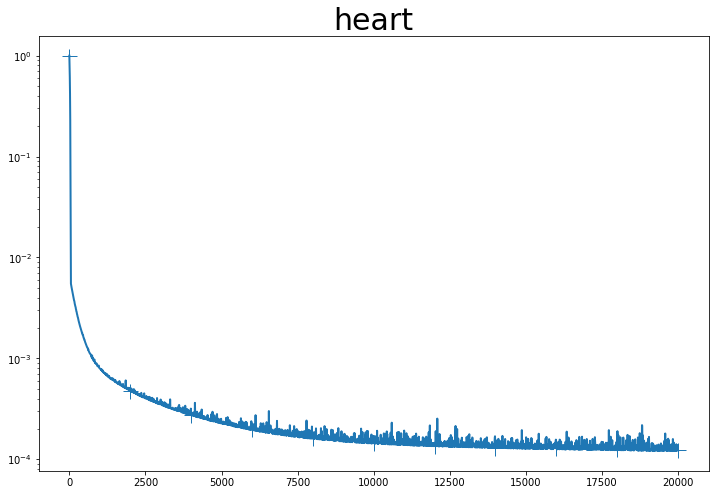

In [19]:
methods = [
        ['SGD_const_stepsize', [gamma, l2, l1, S, batch_size], 
           'SGD', None],
         ['clipped-SGD_const_stepsize', [gamma, lambd*0.0005, l2, l1, S, batch_size], 
           'clipped-SGD', None],
         ['clipped-SGD_const_stepsize_decr_clip', [gamma, 
                                                   lambd_schedule,
                                                   l2, l1, S, batch_size], 
           'd-clipped-SGD', None],
         ['clipped-SSTM', [10000.0, B*0.01, L+l2, l2, S, batch_size], 
           'clipped-SSTM', None],
    ['SSTM', [10000.0, L+l2, l2, S, batch_size], 
           'SSTM', None],
]
mode_y = 'func_vals'

mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 25
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_test.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [20]:
res = read_results_from_file(filename, 'SGD_const_stepsize', [gamma, l2, l1, S, batch_size])

In [21]:
%%time
x = deepcopy(res['last_iter'])
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 26.2 ms, sys: 3.95 ms, total: 30.1 ms
Wall time: 31.7 ms


In [22]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean(grad_deviations**2 - mu))
print(mu)
print(sigma)

66.58394650888705
109.19229714354273


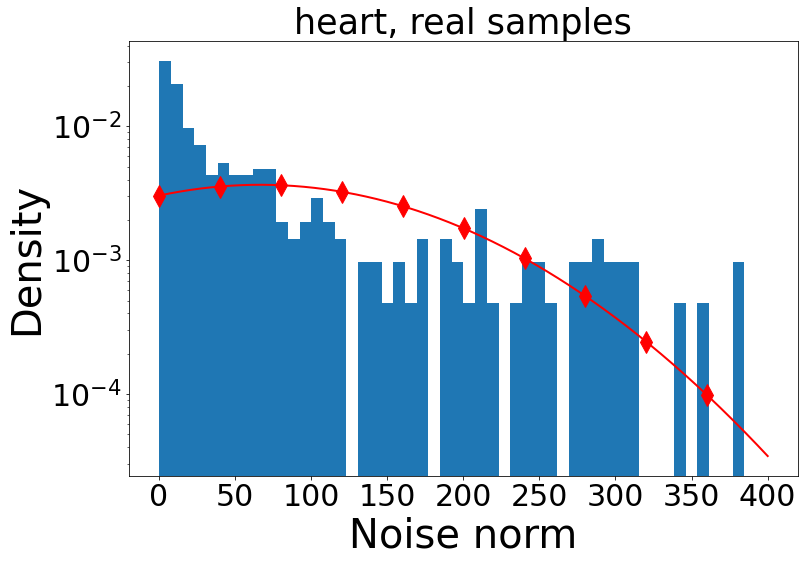

In [23]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=50, density=1, log=True)
temp2 = np.linspace(0, 400, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('heart, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/heart_sgd_last_point.pdf", bbox_inches='tight')

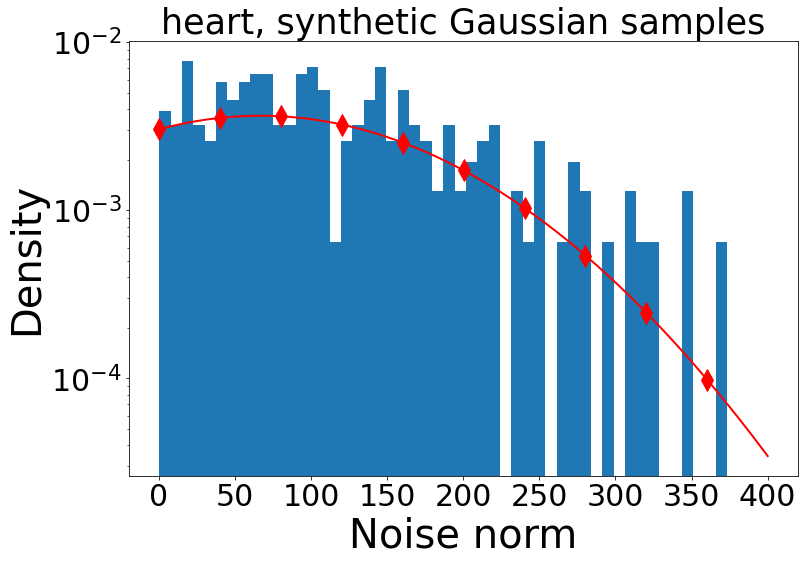

In [24]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=50, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
temp2 = np.linspace(0, 400, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('heart, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/heart_synthetic_sgd_last_iter.pdf", bbox_inches='tight')